<a href="https://colab.research.google.com/github/nyp-sit/mindef-ai/blob/main/day1-pm/ids_autoencoder_v3-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://www.nyp.edu.sg/content/dam/nyp/logo.png" width="238" height="70"/>

<a href="https://colab.research.google.com/github/nyp-sit/mindef-ai/blob/master/day1-pm/ids_autoencoder_v3-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Welcome to the lab! Before we get started here are a few pointers on Jupyter notebooks.

1. The notebook is composed of cells; cells can contain code which you can run, or they can hold text and/or images which are there for you to read.

2. You can execute code cells by clicking the ```Run``` icon in the menu, or via the following keyboard shortcuts ```Shift-Enter``` (run and advance) or ```Ctrl-Enter``` (run and stay in the current cell).

3. To interrupt cell execution, click the ```Stop``` button on the toolbar or navigate to the ```Kernel``` menu, and select ```Interrupt ```.
    

In [42]:
!wget -q https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/codes/utils.py

# Anomaly Detection for Network Traffic (Solution)

<div>           
<center>
    <img src="https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/resources/intrusion_alert.png" width="300" height="200"/>
</center>
</div>

In this lab, we will try to build an anomaly detector for network traffic, which can detect attack traffic such as Denial of Service (DoS) attack. We will make use of two pre-processed network traffic files, which contain features extracted from the raw traffic. These features are extracted from TCP and UDP flows. One file contains only normal traffic, which we will use for training an Autoencoder neural network. The other file contains mixture of normal and attack traffic, which we will use for fine-tuning the threshold of anomaly score, and for final testing.  



## Import libraries

We begin by importing the libraries that we need, mainly *scikit-learn* (which contains some useful methods for scaling the data, and  for calculating various evaluation metrics, such as precision/recall scores), *tensorflow* (which is the deep learning framework that we will use to build the autoencoder neural network) and *matplotlib* (which we will use for data visualization)

In [43]:
# scikit-learn libraries used for evaluation metrics, scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# pandas libraries for manipulating dataframe
import pandas as pd

# numerical library 
import numpy as np

#import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse

import sys
import pickle

from utils import *

## Getting the data

We download the data that we need for this lab. This is a zip file which contain different csv files for different days of network traffic data. After download, the files are unzipped to a directory called ```'ids_dataset'```. You should be able to see the directory at the left sidebar (file browser). 



In [3]:
base_dataset_dir = 'ids_dataset'
datafile_url = 'https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/datasets/ids_dataset.zip'
download_data(base_dataset_dir, datafile_url, extract=True, force=False)

ids_dataset.zip: 144MB [00:13, 10.7MB/s]                           


For this lab exercise, we will use the following two files in the ```ids_dataset``` directory: 

1. *Monday-WorkingHours.pcap_ISCX.csv* - contains features extracted from normal traffic 
2. *Wednesday-workingHours.pcap_ISCX.csv* - contains a mixture of normal traffic and attack traffic such as DoS/DDoS, Slowloris, Goldeneye, etc.  

We use the pandas library to read data from CSV files into panda dataframe. Dataframe is a 2D data structure similar to database table that contains columns and rows. Row represents individual data sample, and columns represent the different features of the data sample.

In [4]:
normal_traffic = os.path.join(base_dataset_dir, 'Monday-WorkingHours.pcap_ISCX.csv')
mixed_traffic = os.path.join(base_dataset_dir, 'Wednesday-workingHours.pcap_ISCX.csv')

# Read the normal (benign) traffic data into pandas dataframe called df_normal
df_normal = pd.read_csv(normal_traffic)

# Read the mixed (benign + attack) traffic data into pandas dataframe called df_mixed
df_mixed = pd.read_csv(mixed_traffic)

## Data Exploration 

Let us explore the data a bit more. We use panda dataframe ```info()``` method to get more information about the feature columns, e.g. number of rows with non-null values for each feature column, and the data type of each feature column. As we we will see from the display below, that we have 78 features (columns 0-77) and the last column (column 78) is the label of the traffic.

In [5]:
# display the information about the dataframe
df_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529918 entries, 0 to 529917
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             529918 non-null  int64  
 1    Flow Duration                529918 non-null  int64  
 2    Total Fwd Packets            529918 non-null  int64  
 3    Total Backward Packets       529918 non-null  int64  
 4   Total Length of Fwd Packets   529918 non-null  int64  
 5    Total Length of Bwd Packets  529918 non-null  int64  
 6    Fwd Packet Length Max        529918 non-null  int64  
 7    Fwd Packet Length Min        529918 non-null  int64  
 8    Fwd Packet Length Mean       529918 non-null  float64
 9    Fwd Packet Length Std        529918 non-null  float64
 10  Bwd Packet Length Max         529918 non-null  int64  
 11   Bwd Packet Length Min        529918 non-null  int64  
 12   Bwd Packet Length Mean       529918 non-nul

**Exercise**

Take a look athe feature column ```Flow Bytes/s``` from the display, what do you observe? 

<details><summary>Click here for answer</summary> 
<br/>
We can see that there a few rows that have missing values for ```Flow Bytes/s```. There are 529854 rows which have non-null values for ```Flow Bytes/s```, compared to others that have 529918 non-null rows. That means there are a total of 64 empty values (or in Machine learning jargon, we call it NaN or Not-a-Number).


</details>

Let's us take a look at the values of the target label to see what are different values for the label (which represents different types of traffic)

In [6]:
df_normal[' Label'].value_counts()

BENIGN    529918
Name:  Label, dtype: int64

Since this dataset only contains 'normal' traffic, the label should only have one value **BENIGN**. Let us also find out what type of labels we have for mixed_traffic.

**Exercise**

In the following cell, add the codes to display the types of labels we have for mixed traffic data. What are different types of attack traffic? 

<details><summary>Click here for answer</summary> 
<br/>
    
```
df_mixed[' Label'].value_counts()
```
    
<br/>
    
From the display, we see that most of the attack traffic are ``DoS Hulk``, the rest being DoS ``GoldenEye``, ``DoS slowloris``, ``DoS Slowhttptest``, and ``Heartbleed``.
    
</details>

In [7]:
## TODO: MODIFY THE LINE BELOW ##

df_mixed[' Label'].value_counts()

BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name:  Label, dtype: int64

From the display, we see that most of the attack traffic are DoS Hulk, the rest being DoS GoldenEye, DoS slowloris, DoS Slowhttptest, and just a very small number of Heartbleed.

Let us also take a look at the statistics of the different feature columns to have some ideas of the numeric values we are dealing with. 

In [8]:
## By default, jupyter notebook only display certain number of rows, we set it to 500 so we can see all the info
pd.set_option('display.max_rows', 500)
df_normal.describe().T

,count,mean,std,min,25%,50%,75%,max
Destination Port,529918.0,1.064437e+04,2.139021e+04,0.000000e+00,53.000000,80.000000,443.000000,6.553500e+04
Flow Duration,529918.0,1.038927e+07,2.875195e+07,-1.000000e+00,176.000000,31303.000000,355744.750000,1.200000e+08
Total Fwd Packets,529918.0,1.039032e+01,8.924128e+02,1.000000e+00,2.000000,2.000000,4.000000,2.197590e+05
Total Backward Packets,529918.0,1.151710e+01,1.173319e+03,0.000000e+00,1.000000,2.000000,3.000000,2.919220e+05
Total Length of Fwd Packets,529918.0,5.324195e+02,6.228642e+03,0.000000e+00,18.000000,68.000000,187.000000,1.323378e+06
Total Length of Bwd Packets,529918.0,1.789841e+04,2.675470e+06,0.000000e+00,0.000000,144.000000,392.000000,6.554530e+08
Fwd Packet Length Max,529918.0,1.908972e+02,4.488338e+02,0.000000e+00,6.000000,40.000000,83.000000,2.336000e+04
Fwd Packet Length Min,529918.0,2.027728e+01,3.627579e+01,0.000000e+00,0.000000,6.000000,40.000000,2.293000e+03
Fwd Packet Length Mean,529918.0,5.074408e+01,9.196471e+01,0.000000e+00,6.000000,38.000000,53.000000,4.638923e+03
Fwd Packet Length Std,529918.0,5.745227e+01,1.465181e+02,0.000000e+00,0.000000,0.000000,26.162951,7.125597e+03


From the display, we can see that there are a few feature columns that have *infinite* (indicated by `inf`) values (as determined by CICFlowMeter). 

**Exercise**

Can you identify which are the columns? 

<details><summary>Click here for answer</summary> 
<br/>
    
The columns ```Flow Bytes/s``` and ```Flow Packets/s``` have **inf** as max value, and thus also have **inf** as mean and stardard deviation.  
    
<br/>
</details>

**Exercise** 

Now add the codes in the cell below to examine the values of `df_mixed`. Are there any abnormal values in `df_mixed` too?

<details><summary>Click here for answer</summary> 
<br/>

```
df_mixed.describe().T
```

<br/>
    
The columns `Flow Bytes/s` and `Flow Packets/s` also contain inf as max value.
    
</details>

In [9]:
# TODO: Add code to find out more info about the numeric values of df_mixed

df_mixed.describe().T

,count,mean,std,min,25%,50%,75%,max
Destination Port,692703.0,5.686869e+03,1.572742e+04,0.0,53.000000,80.000000,4.430000e+02,6.548700e+04
Flow Duration,692703.0,2.800168e+07,4.276680e+07,-1.0,201.000000,61437.000000,8.302437e+07,1.200000e+08
Total Fwd Packets,692703.0,9.556261e+00,7.471978e+02,1.0,2.000000,2.000000,7.000000e+00,2.039430e+05
Total Backward Packets,692703.0,1.021408e+01,9.842046e+02,0.0,1.000000,2.000000,6.000000e+00,2.723530e+05
Total Length of Fwd Packets,692703.0,5.550930e+02,6.163663e+03,0.0,12.000000,82.000000,3.650000e+02,1.224076e+06
Total Length of Bwd Packets,692703.0,1.699644e+04,2.241175e+06,0.0,0.000000,188.000000,1.159500e+04,6.270000e+08
Fwd Packet Length Max,692703.0,2.335939e+02,6.037519e+02,0.0,6.000000,46.000000,3.410000e+02,2.482000e+04
Fwd Packet Length Min,692703.0,1.502218e+01,5.106883e+01,0.0,0.000000,0.000000,3.200000e+01,2.065000e+03
Fwd Packet Length Mean,692703.0,6.055544e+01,1.576438e+02,0.0,6.000000,41.000000,5.666667e+01,4.640758e+03
Fwd Packet Length Std,692703.0,8.289586e+01,2.261261e+02,0.0,0.000000,0.000000,1.289169e+02,6.429191e+03


## Data Preparation

### Data Cleaning 

We will need to clean up the data by removing the *NaN* values and the *Inf* values, because machine learning algorithms has problem dealing with these types of values.  Since we don't have too many rows of *NaN* and *Inf* values, the easiest way is to drop them. The code below first tells pandas to treat *Inf* values as *NaN* (```'mode.use_inf_as_na'```) and then drops all rows that contains *NaN* values (effectively dropping both rows with *NaN* and  *Inf* values)

In [10]:
# Drop rows with NaN and Inf values

with pd.option_context('mode.use_inf_as_na', True):
    df_normal = df_normal.dropna(subset=['Flow Bytes/s', ' Flow Packets/s'], how='all')
    df_mixed = df_mixed.dropna(subset=['Flow Bytes/s', ' Flow Packets/s'], how='all')

**Exercise** 

Now add the code here to see if you still have `NaN` or `Inf` values.  (Hint: refers to the codes in previous cells to see how you can do this)

<details><summary>Click here for answer</summary> 
<br/>
    
You can use `info()`, as well as `describe()` methods to check the values of `df_normal` and `df_mixed`.
e.g. `df_normal.info()`, or `df_normal.describe().T`
    
<br/>

</details>

In [11]:
# TODO: add code here to check if you still have NaN or Inf values

df_normal.info()
df_normal.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529481 entries, 0 to 529917
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             529481 non-null  int64  
 1    Flow Duration                529481 non-null  int64  
 2    Total Fwd Packets            529481 non-null  int64  
 3    Total Backward Packets       529481 non-null  int64  
 4   Total Length of Fwd Packets   529481 non-null  int64  
 5    Total Length of Bwd Packets  529481 non-null  int64  
 6    Fwd Packet Length Max        529481 non-null  int64  
 7    Fwd Packet Length Min        529481 non-null  int64  
 8    Fwd Packet Length Mean       529481 non-null  float64
 9    Fwd Packet Length Std        529481 non-null  float64
 10  Bwd Packet Length Max         529481 non-null  int64  
 11   Bwd Packet Length Min        529481 non-null  int64  
 12   Bwd Packet Length Mean       529481 non-nul

,count,mean,std,min,25%,50%,75%,max
Destination Port,529481.0,1.063081e+04,2.138021e+04,0.000000e+00,53.000000,80.000000,443.000000,6.553500e+04
Flow Duration,529481.0,1.039785e+07,2.876227e+07,-1.000000e+00,176.000000,31313.000000,357068.000000,1.200000e+08
Total Fwd Packets,529481.0,1.039764e+01,8.927809e+02,1.000000e+00,2.000000,2.000000,4.000000,2.197590e+05
Total Backward Packets,529481.0,1.152621e+01,1.173803e+03,0.000000e+00,1.000000,2.000000,3.000000,2.919220e+05
Total Length of Fwd Packets,529481.0,5.328472e+02,6.231194e+03,0.000000e+00,18.000000,68.000000,187.000000,1.323378e+06
Total Length of Bwd Packets,529481.0,1.791318e+04,2.676573e+06,0.000000e+00,0.000000,144.000000,392.000000,6.554530e+08
Fwd Packet Length Max,529481.0,1.910454e+02,4.489884e+02,0.000000e+00,6.000000,40.000000,83.000000,2.336000e+04
Fwd Packet Length Min,529481.0,2.028958e+01,3.628777e+01,0.000000e+00,0.000000,6.000000,40.000000,2.293000e+03
Fwd Packet Length Mean,529481.0,5.077909e+01,9.199341e+01,0.000000e+00,6.000000,38.000000,53.000000,4.638923e+03
Fwd Packet Length Std,529481.0,5.749624e+01,1.465692e+02,0.000000e+00,0.000000,0.000000,26.162951,7.125597e+03


In [12]:
df_mixed.info()
df_mixed.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691406 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             691406 non-null  int64  
 1    Flow Duration                691406 non-null  int64  
 2    Total Fwd Packets            691406 non-null  int64  
 3    Total Backward Packets       691406 non-null  int64  
 4   Total Length of Fwd Packets   691406 non-null  int64  
 5    Total Length of Bwd Packets  691406 non-null  int64  
 6    Fwd Packet Length Max        691406 non-null  int64  
 7    Fwd Packet Length Min        691406 non-null  int64  
 8    Fwd Packet Length Mean       691406 non-null  float64
 9    Fwd Packet Length Std        691406 non-null  float64
 10  Bwd Packet Length Max         691406 non-null  int64  
 11   Bwd Packet Length Min        691406 non-null  int64  
 12   Bwd Packet Length Mean       691406 non-nul

,count,mean,std,min,25%,50%,75%,max
Destination Port,691406.0,5.683120e+03,1.572234e+04,0.0,53.000000,80.000000,4.430000e+02,6.548700e+04
Flow Duration,691406.0,2.805421e+07,4.278968e+07,-1.0,202.000000,61561.000000,8.308687e+07,1.200000e+08
Total Fwd Packets,691406.0,9.570718e+00,7.478982e+02,1.0,2.000000,2.000000,7.000000e+00,2.039430e+05
Total Backward Packets,691406.0,1.023296e+01,9.851272e+02,0.0,1.000000,2.000000,6.000000e+00,2.723530e+05
Total Length of Fwd Packets,691406.0,5.561296e+02,6.169395e+03,0.0,12.000000,82.000000,3.650000e+02,1.224076e+06
Total Length of Bwd Packets,691406.0,1.702833e+04,2.243276e+06,0.0,0.000000,188.000000,1.159500e+04,6.270000e+08
Fwd Packet Length Max,691406.0,2.340283e+02,6.042345e+02,0.0,6.000000,46.000000,3.410000e+02,2.482000e+04
Fwd Packet Length Min,691406.0,1.504801e+01,5.111307e+01,0.0,0.000000,0.000000,3.200000e+01,2.065000e+03
Fwd Packet Length Mean,691406.0,6.066592e+01,1.577708e+02,0.0,6.000000,41.000000,5.683333e+01,4.640758e+03
Fwd Packet Length Std,691406.0,8.305029e+01,2.263099e+02,0.0,0.000000,0.000000,1.290470e+02,6.429191e+03


### Simplify the number of labels into binary labels

In this exercise, we are only interested in knowing if the traffic is 'normal' or 'abnormal', so we will group all the different attack traffic types into just one label, i.e. label '1' (think of 1 as positive case) while the benign traffic will be labelled as 0 (negative case).

In [13]:
df_normal[' Label'] = df_normal[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)
df_mixed[' Label'] = df_mixed[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)

Now let's see our new traffic labels for ```df_mixed```. We should see that they now have only two values 0 and 1.

In [14]:
df_mixed[' Label'].value_counts()

0    439683
1    251723
Name:  Label, dtype: int64

### Create Training dataset and Validation dataset

Here we will create the training set and the validation set. We will use the normal-only traffic (df_normal) as training and validation set. Since we are using unsupervised learning, we do not need the 'Label', so we will drop the label column for our training/validation set.  

Validation data is used during training to check if we over-train our model or in ML jargon, overfit our model to the training set. 


In the code below, we use 20% of data as validation set, and the remaining 80% as training set. 

We use the `train_test_split()` from scikit-learn to help us split the data. We also shuffle the data before we split (`shuffle=True`) to ensure we have similar distribution between train and validation set. We also try to make sure both splits have the same proportion of samples from each traffic type (label), by setting `stratify=df_normal[' Label']`.  We actually do not need to have data stratification here as all samples belong to a single label, i.e. 0 (benign). However, we will need the stratification when we deal with test dataset, as the samples belong to two different labels: 0 and 1. 

In [15]:
# Drop the label column
df_normal_nolabel = df_normal.drop([' Label'], axis=1)

# Split the normal traffic data into Train and Validation set. 
X_train, X_val = train_test_split(df_normal_nolabel, test_size=0.2, shuffle=True, stratify=df_normal[' Label'])

### Create Test dataset 

As mentioned, we will use the mixed traffic data as our test set. We have more than 600,000 samples, we will just use half of the samples for testing. We can use the same `train_test_split` method as convenience method to split the data into half, with the advantage of random shuffling and also make sure each labels are well represented in each half of the split data.

In [16]:
# allocate 50% to fine-tuning set, and 50% to final test set
df_test, _  = train_test_split(df_mixed, test_size=0.5, shuffle=True, stratify=df_mixed[' Label'])

Unlike training data, we do want to keep the label in our test data, as we will use it to help us evaluate the performance of our anomaly detector. 

In the code below, we will separate out the label column and call it `y_test`. The remaining feature columns will be called `X_test`.



In [17]:
y_test = df_test[' Label']
X_test = df_test.drop(' Label', axis=1)

### Scaling the data 

The last step we need to do in our Data Preparation task is to scale the data by removing the mean and scaling to unit variance. Most machine learning algorithms (including neural networks) require input data to be scaled to some small values to be able to learn better. 

Note that we compute the mean and standard deviation from the **training set only** and use the computed mean and standard deviation to scale the validation and the test set. This is to prevent information from validation/test set to leak to training set. 

We use the `StandardScaler()` from Scikit-Learn to compute mean/standard deviation from training data and use same scaler (which learns the mean and std from train set already) to scale the test and validation data automatically.

In [18]:
# Compute the mean and standard deviation using StandardScaler() and transform (scale) the X_train values.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [19]:
# Now we use the scaler computed from X_train to scale the Validation and Test set.
X_val_scaled = scaler.transform(X_val)

**Exercise**

Complete the codes below to scale the  `X_test`. 

<details><summary>Click here for answer</summary>
    
<br/>
    
```
X_tune_scaled = scaler.transform(X_tune)
X_test_scaled = scaler.transform(X_test)
```
</details>
    

In [20]:
# TODO: Scale the tuning and test set 
X_test_scaled = scaler.transform(X_test)

In [21]:
# Good to make sure that our training set does not contain any NaN values, just in case, before we start training.
assert not np.any(np.isnan(X_train_scaled))

Congratulations, we have finished our data preparation !!! As in all machine learning projects, data preparation is always the **most** time consuming phase.

## Build the Variational Autoencoder (VAE) network

Let us define a couple of diemensions. 

We set the input dimension (input_dim) to be number of columns (features) in `X_train`.  `X_train.shape` will give you a tuple of (#rows, #columns). To get the value of #columns, we take the 2nd value in the tuple (0 being 1st value, 1 being 2nd, as index starts from 0)

We also set the latent dimension. Recall from the lecture that Autoencoder will try to learn the essential information from the data and try to compress the information into the 'latent space'. `latent_dim` is the size of the latent space.

In [22]:
# we set the input dimensions to the number of features in X, i.e. 78.  
input_dim = X_train.shape[1]

# we set the dimension of the latent representation to 20 neurons, 
# in other words, we want to condense the information in the input into the latent space of 20 neurons
latent_dim = 20

### Encoder Network

We will now build the Encoder part of the Variational Autoencoder (VAE). One main difference between a Variational Autoencoder and a normal Autoencoder is that VAE learns the mean and the standard deviation of the inputs, basically learning the distribution of the inputs. It will then sample from this learnt distribution to produce codings that can be used by the decoder to produce an output.

<img src="https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/resources/vae_encoder.png" height='500' width='400'>

In the following code, we construct our encoder which consists of 4 hidden layers, a latent layer (which encodes the mean and standard deviation).
- 1st hidden layer with 80 neurons
- 2nd hidden layer with 60 neurons
- 3rd hidden layer with 50 neurons 
- 4th hidden layer with 32 neurons 
- latent layer for encoding mean with `laten_dim` neurons
- latent layer for encoding log_variance with `latent_dim` neurons

We have two latent layers, one for `codings_mean` which is the mean, and one for `log_var` which is the log of variance. Log of variance is used instead of standard deviation, as it is mathematically easier to use log of variance for computation purpose.  

Note also that we use L1 regularization in some of the layers (`tf.keras.regularizers.l1`). Regularization is one way to prevent overfitting. 

`Sampling()` is a function used to sample from this learnt normal distribution with the learnt mean and variance. (Note: You can examine the `utils.py` file if you want to see how the sampling is done).


In [23]:
inputs = Input(shape=(input_dim,), name='Input')
z = Dense(80, activation='tanh', name='hidden1')(inputs)
z = Dense(60, activation='tanh', name='hidden2')(z)
z = Dense(50, activation='tanh', 
          activity_regularizer=tf.keras.regularizers.l1(1e-3), 
          name = 'hidden3')(z)
z = Dense(32, activation='tanh', 
          activity_regularizer=tf.keras.regularizers.l1(1e-3), 
          name = 'hidden4')(z)
codings_mean = Dense(latent_dim, name='mean')(z)
codings_log_var = Dense(latent_dim, name='log_var')(z)
codings = Sampling()([codings_mean, codings_log_var])
vae_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

vae_encoder.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 78)]         0                                            
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 80)           6320        Input[0][0]                      
__________________________________________________________________________________________________
hidden2 (Dense)                 (None, 60)           4860        hidden1[0][0]                    
__________________________________________________________________________________________________
hidden3 (Dense)                 (None, 50)           3050        hidden2[0][0]                    
_______________________________________________________________________________________

### Decoder Network

Here, we will build the Decoder part of the VAE. 

<img src="https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/resources/vae_decoder.png" height="500" width="400"/>

The decoder will be 'inverse' copy of the encoder, with each layer having more and more neurons (32 -> 50 -> 60 -> 80 -> input_dim) until it get backs to the original input size. 

In [24]:
decoder_inputs = Input(shape=[latent_dim], name='codings')
x = Dense(32, activation='tanh', name='hidden5')(decoder_inputs)
x = Dense(50, activation='tanh', name='hidden6')(x)
x = Dense(60, activation='tanh', name='hidden7')(x)
x = Dense(80, activation='tanh', name='hidden8')(x)
outputs = Dense(input_dim, activation="linear", name='output')(x)
vae_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])
vae_decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
hidden5 (Dense)              (None, 32)                672       
_________________________________________________________________
hidden6 (Dense)              (None, 50)                1650      
_________________________________________________________________
hidden7 (Dense)              (None, 60)                3060      
_________________________________________________________________
hidden8 (Dense)              (None, 80)                4880      
_________________________________________________________________
output (Dense)               (None, 78)                6318      
Total params: 16,580
Trainable params: 16,580
Non-trainable params: 0
__________________________________________________

The codes below are just specifying the two loss functions that the model will use to try to minimise the losses at each training step. 

The first loss function is the MSE (mean-squared-error or mse) loss which is computed from the differences between predicted output and expected output.

\begin{equation*}
\frac{1}{m}\sum_{i=1}^m (\hat{y}_{i} - y_i)^2
\end{equation*}

wher $\hat{y}$ is the predicted output and $y$ is the actual value. 

The second loss which is the latent_loss is given by the following formula: 

<img src="https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/resources/latent_loss_formula.png" height='80' width='280'/>

In [27]:
_, _, codings = vae_encoder(inputs)
reconstructions = vae_decoder(codings)
vae = Model(inputs=[inputs], outputs=[reconstructions])

# Compute the latent loss (based on mean and variance)
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

# reconstruction loss is based on MSE loss
reconstruction_loss = losses.mse(inputs, reconstructions)
reconstruction_loss *= input_dim

# total loss for VAE is the mean of both latest and reconstruction loss
vae_loss = K.mean(latent_loss + reconstruction_loss)
vae.add_loss(vae_loss)
rmsprop = RMSprop()
vae.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['mean_squared_error'])


In [28]:
vae.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 78)]         0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 20), (None,  17182       Input[0][0]                      
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 78)           16580       functional_1[1][2]               
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 80)           6320        Input[0][0]                      
_______________________________________________________________________________________

### Training the Network 

Now we are ready to train our VAE. Neural network like VAE learns by trying to minimise the training loss (i.e the error between its predicted output and the actual expected output) at each training cycle (which we call *epoch*). 

As the network learns, training loss and validation loss will keep decreasing (sometimes up and down, but in general downward trend) as the network makes less and less mistakes. So normally we want to train the network until it has very low loss or the loss has plateaued. 

In the `fit()` function below, we pass `X_train_scaled` as both the input and expected output (so called target labels). We also pass `X_val_scaled` for calculating our validation errors to see if our model is overfitting.

An overfitted model means it performs very well on the training data but does very badly on unseen new data. The performance on unseen data is the one we are most interested in. The larger the difference between validation and training loss, the more overfitting it is. So we would want the gap to be small. 

In [30]:
train = True
num_epochs = 20
batch_size = 512

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = vae.fit(X_train_scaled, X_train_scaled, 
                  epochs=num_epochs, 
                  batch_size=batch_size, 
                  verbose=1, 
                  shuffle=True,
                  validation_data = (X_val_scaled, X_val_scaled),
                  callbacks=[tensorboard_cb])

Epoch 1/20
828/828 [==============================] - 7s 8ms/step - loss: 25.3126 - mean_squared_error: 0.2566 - val_loss: 38.5909 - val_mean_squared_error: 0.4248
Epoch 2/20
828/828 [==============================] - 7s 8ms/step - loss: 24.7106 - mean_squared_error: 0.2492 - val_loss: 37.7407 - val_mean_squared_error: 0.4146
Epoch 3/20
828/828 [==============================] - 7s 8ms/step - loss: 24.1984 - mean_squared_error: 0.2430 - val_loss: 37.1974 - val_mean_squared_error: 0.4081
Epoch 4/20
828/828 [==============================] - 7s 9ms/step - loss: 23.7645 - mean_squared_error: 0.2378 - val_loss: 37.2386 - val_mean_squared_error: 0.4073
Epoch 5/20
828/828 [==============================] - 7s 8ms/step - loss: 23.3211 - mean_squared_error: 0.2325 - val_loss: 37.1210 - val_mean_squared_error: 0.4079
Epoch 6/20
828/828 [==============================] - 7s 8ms/step - loss: 23.0680 - mean_squared_error: 0.2294 - val_loss: 37.0314 - val_mean_squared_error: 0.4055
Epoch 7/20
828/8

Now we will plot the training and validation loss.

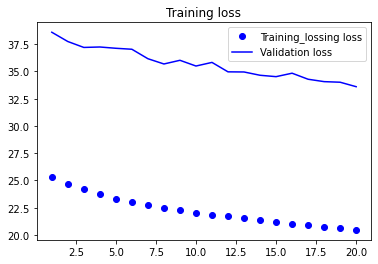

In [31]:
plot_training_loss(history.history)


**Exercise**

Go back to the code cell above and change the epochs to larger value (e.g. 20) and run the training again. What do you observe? 

<details><summary>Click here for answer</summary>

As we increase the number of epochs, training and validation loss will keep decreasing until they plateau at some point. When the loss plateued, the network is unable to improve anymore. 


### Evaluate the trained model on Test Dataset

Now let us compare the reconstruction error (MSE) between training set (the clean, benign traffic) and that of test set (the one with benign + attack traffic). In the below, we compute the mean of the entire data set (of X_train_scaled and X_tune_scaled), as we just want to have a feel of the overall error of the two different data sets.

In [32]:
X_train_preds = vae.predict(X_train_scaled)

In [33]:
X_train_mse  =   np.square(X_train_scaled - X_train_preds).mean()
print(X_train_mse)

0.19702559512457352


**Exercise**

Complete the code below to compute and display the MSE of test dataset. 

What do you observe about the value of MSE? Is it higher or lower than the MSE of the training set?

<details><summary>Click here for answer</summary>
<br/>
    
```
X_test_preds = vae.predict(X_test_scaled)
X_test_mse = np.square(X_test_scaled - X_test_preds).mean()
print(X_test_mse)
```

<br/>
    
From the value of `X_test_mse`, we can see that the MSE (the mean squared error) for the test dataset is much much than the training set. The presence of attack traffic make it more difficult for Variational Autoencoder to reconstruct the input accurately, leading to higher MSE.
    
</details>

In [34]:
# TODO: complete the code below

X_test_preds = vae.predict(X_test_scaled)
X_test_mse = np.square(X_test_scaled - X_test_preds).mean()
print(X_test_mse)

1.7423298583934024


### Compute the distance between Train set and the 'Tuning' set. 

Now let us compute the 'distance' between each sample and its reconstructed version. Think of 'distance' as the difference between two different multi-dimensional vector. As each sample is a multi-demensional vector, the difference will be multi-dimensional as well. Therefore we will use the [*Frobenius norm*](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm) to measure the distance between the sample and its reconstruction.  In the following, we use the numpy library function `np.linalg.norm()` to compute the *Frobenius norm*.  

**Note:** 

In this section, we are interested in knowing error of each sample, unlike the previous section, where we are just looking at mean error rate of entire train or test set.  The reason is we want to compare error of each sample with the error threshold to determine if the sample is anomalous or not.

In [35]:
X_train_preds = vae.predict(X_train_scaled)
X_train_errors = np.linalg.norm(X_train_scaled - X_train_preds, axis=1)
print('min = ',X_train_errors.min())
print('max = ',X_train_errors.max())
print('mean = ',X_train_errors.mean())
print('std = ',X_train_errors.std())

min =  0.24397046810901668
max =  662.7994824353624
mean =  1.5257856685323468
std =  3.611095104110883


In [36]:
X_test_preds = vae.predict(X_test_scaled)
X_test_errors = np.linalg.norm(X_test_scaled - X_test_preds, axis=1)
print('min = ', X_test_errors.min())
print('max = ',X_test_errors.max())
print('mean = ',X_test_errors.mean())
print('std = ', X_test_errors.std())

min =  0.24631532848258136
max =  601.1703859859516
mean =  6.244918261618057
std =  9.843329768984967


## Choosing the Anomlay Score Threshold

Based on above, it seems reasonable to set the threshold at mean + 3 std deviation of training errors. In the absence of labels to help us adjust threshold for the anomaly detector, we could set the threshold derived by statistical means.

In [37]:
threshold = X_train_errors.mean() + 3 * X_train_errors.std()
#threshold = 3.5

print(threshold)

12.359070980864995


Let us use this threshold on the test set. If the error of a test sample is greater than the threshold, assign it a label 1 (attack), otherwise, assign it a label 0 (benign). We use `y_test_pred` to keep our predicted labels and compare `y_test_pred` to `y_test` (the ground truth label we have) to compute various evaluation metrics (such as precision recall)

In [38]:
anomalies = X_test_errors > threshold
y_test_pred = []
for is_anomaly in anomalies: 
    if is_anomaly: 
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)

Now, let's see how well this statistically determined threshold perform on our test set. We are able to compute the precision, recall and accuracy of our model based on our test set labels. In many cases, we do not enjoy the luxury of having a labelled dataset like what we have.

The code below calculates the *precision, recall and accuracy* of model on test data.

In [39]:
precision = precision_score(y_test, y_test_pred, pos_label=1)
recall = recall_score(y_test, y_test_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_test_pred)
print('threshold={:.2f}, precision={}, recall={}, acc={}'.format(threshold, precision, recall, accuracy))

threshold=12.36, precision=0.969053934571176, recall=0.5921453031518897, acc=0.8446267460797274


**Exercise**

What can you say about the performance of model, in terms of precision, recall and accuracy. 

<details><summary>Click here for answer</summary>

The model has high precision but low recall. 
    
</details>

Let's just plot the data points. The normal data is marked green and the abnormal data is marked as red. The current threshold is shown as blue horizontal line. As there are close to 350,000 data points, it will be difficult to visualize on the graph. Let's us just plot first 1000 data points to see how the errors of each data point are distributed and how are they compared to the threshold.

y counts 0    643
1    357
Name:  Label, dtype: int64


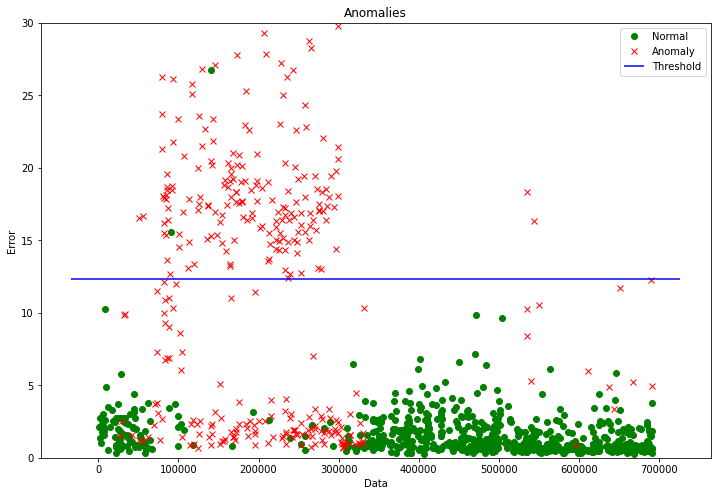

In [40]:
draw_anomaly(y_test[:1000], X_test_errors[:1000], threshold)

You can see that very few 'normal' data points lie above the threshold set. Those that are above are mostly anomalous data points. We thus have very few false positives. This shows that we have very **high precision**.  On the other hand, we find that many 'anomalous' data points actually found the threshold, and thus not flagged as 'anomaly'. We thus have quite a lot of false negatives. This shows that we have very **low recall**. 

**Exercise**

How do you improve the recall (sensitivity)? If you improve the recall, what happens to the precision? 
Try out your idea by modifying the codes. 

<details><summary>Click here for answer</summary>
<br/>
    
You can change the threshold to a lower value to improve the recall (less false negatives).
However, it will also decrease the precision (more false positives). 
There is trade-off between recall and precision. 
    
Change threshold to say some lower value (e.g. 5) and re-run the cells.
    
</details>

**Exercises (Optional)**

- Try your trained model on another test dataset (e.g. Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv) and see how it performs
- You can try to change the Autoencoder's hidden layers to have more or less units and observe the training loss and validation loss
- You can try to change the latent dimension to be larger or smaller and observe the training and validation loss.